# SVM - Kernel

* Potentielle Kernel: RBF, Polynomial, Spectral Mixture Kernel, Sigmoid Kernel
* Calculate SVM using dual decision functions
* Thus: Model theta has as many parameters as examples.
* Kernel function: Measure of similarity between instances.
* Hence: How similar is instance x to each other trainings instance?
* Derivation from the primal into the dual form is necessary (lecture).

Optimization criterion of the dual SVM:

$$
max_{\beta} \sum_{i=1}^n \beta_i - \frac{1}{2} \sum_{i,j=1}^n \beta_i \beta_j y_i y_j k(x_i,x_j) \text{, such that } 0 \leq \beta_i \leq \lambda
$$

* Optimization over parameters beta
* Sparse solution (solution of a problem where most of the elements are zero)
* Reason: Samples only appear as pairwise inner products.
* Sparsity desired property because it often leads to simpler, more interpretable models.
* QPP - Quadratic programming problem

Dual from of the decision function:

$$
f_{\beta}(x)= \sum_{x_i\in SV} \beta_i y_i k(x_i, x)
$$

(SV = Support Vectors)

* Only the support vectors (points with non-zero beta_i) contribute to the decision function.
* Decision function is weighted sum over the support vectors.
* Decides the class based on the sign of this sum.


**Hint:**

This code is a implementation of kernelized empirical risk minimization that aligns with the SVM concepts but uses gradient descent instead of directly solving the dual problem via quadratic programming.

## Data Import

In [1]:
from scipy.io import loadmat
from sklearn.model_selection import ParameterGrid
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from svm_helper import SvmHelper
from dataset import BaseDataset
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

file_path = "../../data/laser.mat"
mat_dict = loadmat(file_path)

dataset = BaseDataset(mat_dict, "X", "Y")

Checking path: /Users/marleenstreicher/Documents/git/IDA_Laser/IDA_Laser/data_split_indices.pkl
Path exists: True


## DTW Kernel

DTW = Dynamic Time Warping - A way to measure the similarity between two sequences, which vary in length or be misaligned in time.

Given a metric $d: X \times X \rightarrow \mathbb{R}_{\geq 0}$ on the input space $X$, the family of *DTW Kernels* is given as:

$$ k_{\text{DTW}}(x, x') = e^{- \lambda d_{\text{DTW}}(x, x'; d)}, $$

* Distance measure $d_{DTW}$ is heart of DTW and is computed by a recursive function $\gamma(i, j)$.
* $\gamma(i, j)$ builds up the minimal distance between the sequences uop to position i,j.
* Computation of DTW distance: Dynamic programming with a $(|x|+1) \times (|x'|+1)$ grid.

**Note:**

$$
d_{DTW}(x,x´;d) = \gamma(\mid x\mid,\mid x´\mid )
$$

$$ 
\gamma(i, j) = \begin{cases} d(x_i, x_j') + \min\left(\gamma(i-1, j-1), \gamma(i-1, j), \gamma(i, j-1)\right) & (1 \leq i \leq |x|, \, 1 \leq j \leq |x'|), \\ 
\infty & i = 0 \vee j = 0, \\
0 & (i, j) = (0, 0). \end{cases}
$$

* $\gamma(i, j)$ is calculated all possible combinations of $j$ and $i$, starting from $\gamma(0, 0)$ up to $\gamma(\mid x\mid,\mid x´\mid )$

Table:

|     | 0   | 2   | 4   | 6   |
|-----|-----|-----|-----|-----|
| 0   | 0   | ∞   | ∞   | ∞   |
| 1   | ∞   | 1   | 9   | 25  |
| 3   | ∞   | 2   | 2   | 14  |
| 4   | ∞   | 5   | 2   | 8   |


$$ \gamma(1, 1) = (1 - 2)^2 + \min(\gamma(0, 0), \gamma(0, 1), \gamma(1, 0)) = 1 + 0 = 1 $$
$$\gamma(2, 2) = (3 - 4)^2 + \min(\gamma(1, 1), \gamma(1, 2), \gamma(2, 1)) = 1 + 1 = 2 $$

The final DTW distance is:

$$
\gamma(3, 3) = 8
$$






<img src="../../images/DTW_dynamic_programming.png" alt="Image" style="width:30%">

Figure A: Example of a DTW $\gamma(i, j)$.



In [2]:
param_grid = {
    'epsilon': [1e-4, 1e-5, 1e-6],
    'alpha_0': [0.001, 0.01, 0.1, 1],
    'lambda_value': [0.001, 0.01, 0.1, 1.0, 10.0]
}

def dtw_kernel(seq1, seq2):
    return np.exp(-SvmHelper.d_DTW(seq1, seq2, SvmHelper.calculate_euclidean_distance))

def train_model_with_params(params, verbose = False):
    theta = SvmHelper.regularised_kernel_erm_batch(dataset.train_inputs, dataset.train_labels,
                                                            kernel_function=dtw_kernel, 
                                                            max_iterations=100,
                                                            epsilon=params['epsilon'], 
                                                            alpha=params['alpha_0'], 
                                                            lbda=params['lambda_value'])
    
    if theta is None:
        return -float('inf')

    predictions = SvmHelper.predict_kernel(theta=theta, kernel_function=dtw_kernel, test_inputs=dataset.test_inputs, train_inputs=dataset.train_inputs)

    if predictions is None:
        return -float('inf') 
    
    accuracy = accuracy_score(dataset.test_labels, predictions)

    if verbose == True:
        print(f"Accuracy with current params: {accuracy}")
    
    return accuracy

best_params = None
best_score = 0.0  

for params in ParameterGrid(param_grid):
    score = train_model_with_params(params)
    if score > best_score: 
        best_score = score
        best_params = params

print("Best parameters found:", best_params)
print("Best score:", best_score)

os.system('say "Parameter search is ready."')

Best parameters found: {'alpha_0': 0.001, 'epsilon': 0.0001, 'lambda_value': 0.001}
Best score: 0.975


0

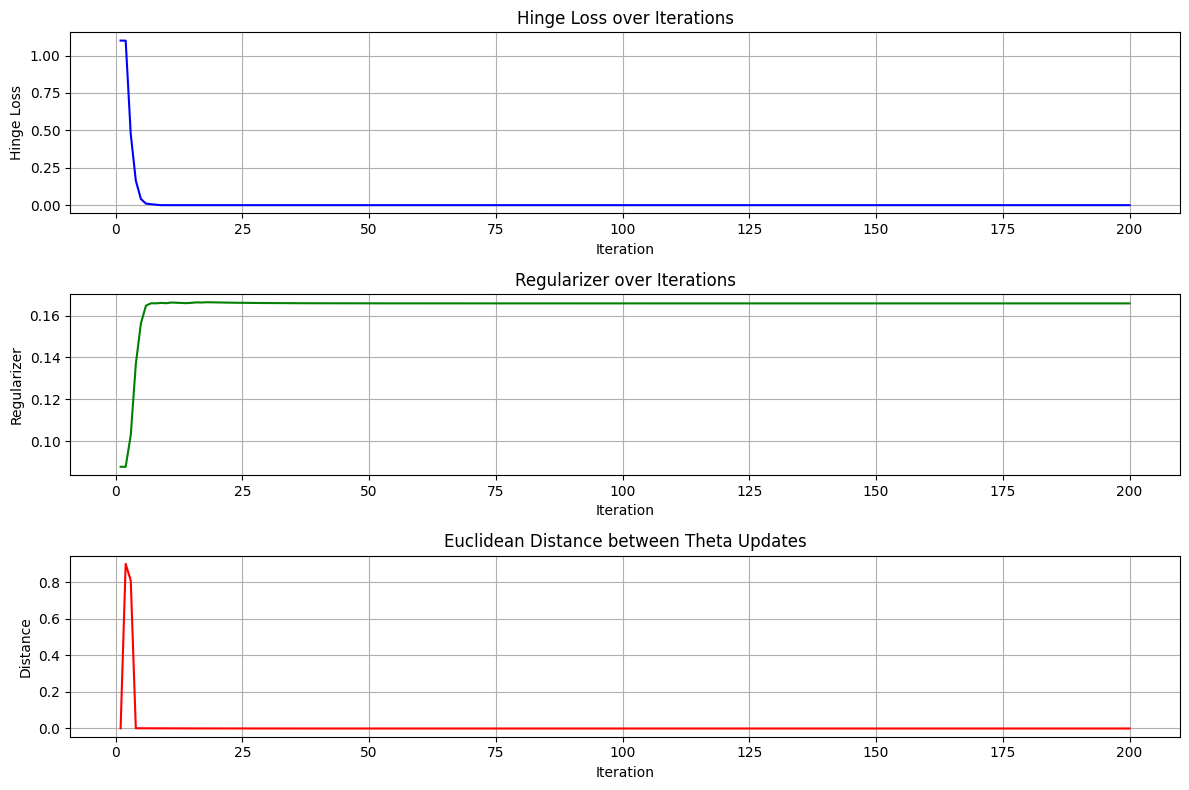

accuracy = 0.975


0

In [7]:
#Best parameters found: {'alpha_0': 0.001, 'epsilon': 0.0001, 'lambda_value': 0.001}

theta = SvmHelper.regularised_kernel_erm_batch(
    inputs=dataset.train_inputs,
    labels=dataset.train_labels,
    kernel_function=dtw_kernel, 
    max_iterations=200,
    alpha=best_params['alpha_0'], 
    epsilon=best_params['epsilon'], 
    lbda=best_params['lambda_value'],  
    verbose=False,
    figure=True
)

predictions = SvmHelper.predict_kernel(theta=theta, kernel_function=dtw_kernel, test_inputs=dataset.test_inputs, train_inputs=dataset.train_inputs)
accuracy = accuracy_score(dataset.test_labels, predictions)
print(f'{accuracy = }')
os.system('say "Training is ready."')


### Evaluation